In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

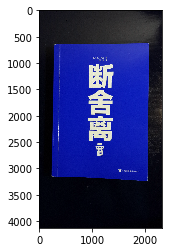

In [2]:
doc_image = cv2.imread('doc1.jpg')
plt.imshow(doc_image)
plt.show()

In [3]:
min_w = 200
height, width, _ = doc_image.shape
scale = min(10., width * 1. / min_w)
height_rescale = int(height * 1. / scale)
width_rescale = int(width * 1. / scale)
height_rescale, width_rescale

(412, 232)

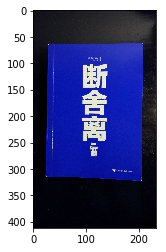

In [4]:
doc_copy = np.copy(doc_image)
doc_copy = cv2.resize(doc_copy, (width_rescale, height_rescale))
plt.imshow(doc_copy)
plt.show()

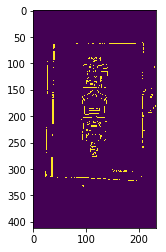

In [5]:
gray = cv2.cvtColor(doc_copy, cv2.COLOR_BGR2GRAY)
high_threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[0]
low_threshold = high_threshold * 0.5
canny = cv2.Canny(gray, low_threshold, high_threshold*1.7)
plt.imshow(canny)
plt.show()

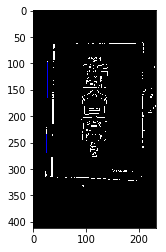

In [6]:
lines = cv2.HoughLinesP(canny, 1, np.pi / 180, width_rescale // 3, None, width_rescale / 3, 20)
gray_rgb = cv2.cvtColor(canny, cv2.COLOR_GRAY2RGB)

class Line:
    def __init__(self, l):
        self.point = l
        x1, y1, x2, y2 = l
        self.c_x = (x1 + x2) / 2
        self.c_y = (y1 + y2) / 2

horizontal, vertical = [], []
for line in lines[0]:
    x1, y1, x2, y2 = line
    if abs(x1 - x2) > abs(y1 - y2):
        horizontal.append(Line(line))
    else:
        vertical.append(Line(line))
    cv2.line(gray_rgb, (x1, y1), (x2, y2), (0, 0, 255), 1)
    
plt.imshow(gray_rgb)
plt.show()

In [7]:
if len(horizontal) < 2:
    if not horizontal or horizontal[0].c_y > height_rescale / 2:
        horizontal.append(Line((0, 0, width_rescale - 1, 0)))
    if not horizontal or horizontal[0].c_y <= height_rescale / 2:
        horizontal.append(Line((0, height_rescale - 1, width_rescale - 1, height_rescale - 1)))

if len(vertical) < 2:
    if not vertical or vertical[0].c_x > width_rescale / 2:
        vertical.append(Line((0, 0, 0, height_rescale - 1)))
    if not vertical or vertical[0].c_x <= width_rescale / 2:
        vertical.append(Line((width_rescale - 1, 0, width_rescale - 1, height_rescale - 1)))

horizontal.sort(key=lambda l: l.c_y)
vertical.sort(key=lambda l: l.c_x)

In [8]:
def intersection(l1, l2):
    x1, y1, x2, y2 = l1.point
    x3, y3, x4, y4 = l2.point
    a1, b1 = y2 - y1, x1 - x2
    c1 = a1 * x1 + b1 * y1
    a2, b2 = y4 - y3, x3 - x4
    c2 = a2 * x3 + b2 * y3
    det = a1 * b2 - a2 * b1
    assert det, 'lines are parallel'
    return (1. * (b2 * c1 - b1 * c2) / det, 1. * (a1 * c2 - a2 * c1) / det)

In [9]:
for l in [horizontal[0], vertical[0], horizontal[-1], vertical[-1]]:
    x1, y1, x2, y2 = l.point
    cv2.line(gray_rgb, (x1, y1), (x2, y2), (0, 255, 255), 1)

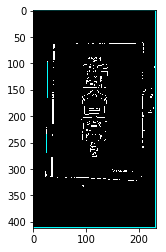

In [10]:
plt.imshow(gray_rgb)
plt.show()

In [11]:
img_pts = [intersection(horizontal[0], vertical[0]), intersection(horizontal[0], vertical[-1]),
           intersection(horizontal[-1], vertical[0]), intersection(horizontal[-1], vertical[-1])]

In [12]:
for i, p in enumerate(img_pts):
    x, y = p
    img_pts[i] = (x * scale, y * scale)
    cv2.circle(gray_rgb, (int(x), int(y)), 1, (255, 255, 0), 3)

In [13]:
w_a4, h_a4 = 1654, 2339
dst_pts = np.array(((0, 0), (w_a4 - 1, 0), (0, h_a4 - 1), (w_a4 - 1, h_a4 - 1)), np.float32)
img_pts = np.array(img_pts, np.float32)
transmtx = cv2.getPerspectiveTransform(img_pts, dst_pts)
wrapped_img = cv2.warpPerspective(doc_image, transmtx, (w_a4, h_a4))

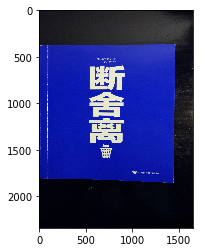

In [14]:
plt.imshow(wrapped_img)
plt.show()